Remote Sensing Systems (RSS, http://www.ssmi.com/) provide machine readable curated datasets of satellite measurements, and the website also explains how they were obtained, processed etc.
The temperature data is called MSU (Microwave Sounding Units), that operated between 1978-2005, and AMSU (Advanced Microwave Sounding Units) from 1998. They provide 4 main datasets:

* **TLT** (Temperature Lower Troposphere): MSU channel 2 by subtracting measurements made at different angles from each other
* **TMT** (Temperature Middle Troposphere): MSU channel 2
* **TTS** (Temperature Troposphere Stratosphere): MSU channel 3
* **TLS** (Temperature Lower Stratosphere): MSU channel 4

The AMSU also provides channels 10-14 (datasets available from RSS), which measure temperatures higher in the stratosphere than the highest MSU channel (4).

In [1]:
#!wget http://www.remss.com/data/msu/data/netcdf/uat4_tb_v03r03_avrg_chTLT_197812_201308.nc3.nc
#!mv uat4_tb_v03r03_avrg_chTLT_197812_201308.nc3.nc data/

In [2]:
#!wget http://www.remss.com/data/msu/data/netcdf/uat4_tb_v03r03_anom_chTLT_197812_201308.nc3.nc
#!mv uat4_tb_v03r03_anom_chTLT_197812_201308.nc3.nc data/

### Weight functions

In [3]:
%pylab inline
import urllib2
import os
from IPython.display import Image

def download(url, dir):
    """Saves file 'url' into 'dir', unless it already exists."""
    filename = os.path.basename(url)
    fullpath = os.path.join(dir, filename)
    if os.path.exists(fullpath):
        print "Already downloaded:", filename
    else:
        print "Downloading:", filename
        open(fullpath, "w").write(urllib2.urlopen(url).read())

Populating the interactive namespace from numpy and matplotlib


In [4]:
download("http://www.remss.com/data/msu/weighting_functions/std_atmosphere_wt_function_chan_TTS.txt", "data")
download("http://www.remss.com/data/msu/weighting_functions/std_atmosphere_wt_function_chan_TLS.txt", "data")
download("http://www.remss.com/data/msu/weighting_functions/std_atmosphere_wt_function_chan_tlt_land.txt", "data")
download("http://www.remss.com/data/msu/weighting_functions/std_atmosphere_wt_function_chan_tlt_ocean.txt", "data")
download("http://www.remss.com/data/msu/weighting_functions/std_atmosphere_wt_function_chan_tmt_land.txt", "data")
download("http://www.remss.com/data/msu/weighting_functions/std_atmosphere_wt_function_chan_tmt_ocean.txt", "data")

Already downloaded: std_atmosphere_wt_function_chan_TTS.txt
Already downloaded: std_atmosphere_wt_function_chan_TLS.txt
Already downloaded: std_atmosphere_wt_function_chan_tlt_land.txt
Already downloaded: std_atmosphere_wt_function_chan_tlt_ocean.txt
Already downloaded: std_atmosphere_wt_function_chan_tmt_land.txt
Already downloaded: std_atmosphere_wt_function_chan_tmt_ocean.txt


In [5]:
D = loadtxt("data/std_atmosphere_wt_function_chan_TTS.txt", skiprows=6)
h = D[:, 1]
wTTS = D[:, 5]

In [6]:
D = loadtxt("data/std_atmosphere_wt_function_chan_TLS.txt", skiprows=6)
assert max(abs(h-D[:, 1])) < 1e-12
wTLS = D[:, 5]

In [7]:
D = loadtxt("data/std_atmosphere_wt_function_chan_tlt_land.txt", skiprows=7)
assert max(abs(h-D[:, 1])) < 1e-12
wTLT_land = D[:, 5]

In [8]:
D = loadtxt("data/std_atmosphere_wt_function_chan_tlt_ocean.txt", skiprows=7)
assert max(abs(h-D[:, 1])) < 1e-12
wTLT_ocean = D[:, 5]

In [9]:
D = loadtxt("data/std_atmosphere_wt_function_chan_tmt_land.txt", skiprows=7)
assert max(abs(h-D[:, 1])) < 1e-12
wTMT_land = D[:, 5]

In [10]:
D = loadtxt("data/std_atmosphere_wt_function_chan_tmt_ocean.txt", skiprows=7)
assert max(abs(h-D[:, 1])) < 1e-12
wTMT_ocean = D[:, 5]

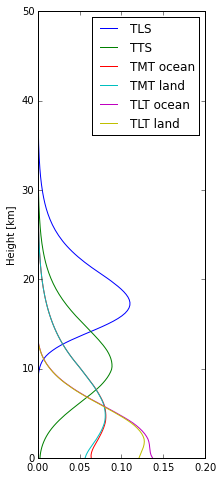

<IPython.core.display.Image object>

In [11]:
figure(figsize=(3, 8))
plot(wTLS, h/1000, label="TLS")
plot(wTTS, h/1000, label="TTS")
plot(wTMT_ocean, h/1000, label="TMT ocean")
plot(wTMT_land, h/1000, label="TMT land")
plot(wTLT_ocean, h/1000, label="TLT ocean")
plot(wTLT_land, h/1000, label="TLT land")
xlim([0, 0.2])
ylim([0, 50])
legend()
ylabel("Height [km]")
show()
Image(url="http://www.ssmi.com/msu/img/wt_func_plot_for_web_2012.all_channels2.png", embed=True)

### Netcdf data

In [12]:
from netCDF4 import Dataset
from numpy.ma import average

In [13]:
rootgrp = Dataset('data/uat4_tb_v03r03_avrg_chtlt_197812_201504.nc3.nc')
list(rootgrp.variables)

[u'longitude',
 u'latitude',
 u'time',
 u'climatology_time',
 u'longitude_bounds',
 u'latitude_bounds',
 u'time_bounds',
 u'climatology_time_bounds',
 u'brightness_temperature',
 u'brightness_temperature_climatology',
 u'offset_values',
 u'target_factor_values',
 u'tb_factor_values',
 u'msu_amsu_offsets',
 u'satellites_used']

In [14]:
# 144 values, interval [-180, 180]
longitude = rootgrp.variables["longitude"][:]
# 72 values, interval [-90, 90]
latitude = rootgrp.variables["latitude"][:]
# 144 rows of [min, max]
longitude_bounds = rootgrp.variables["longitude_bounds"][:]
# 72 rows of [min, max]
latitude_bounds = rootgrp.variables["latitude_bounds"][:]
# time in days, 1978 - today
time = rootgrp.variables["time"][:]
# time in years
years = time / 365.242 + 1978
# 12 values: time in days for 12 months in a year
time_climatology = rootgrp.variables["climatology_time"][:]
# (time, latitude, longitude)
brightness_temperature = rootgrp.variables["brightness_temperature"][:]
# (time_climatology, latitude, longitude)
brightness_temperature_climatology = rootgrp.variables["brightness_temperature_climatology"][:]

We need to calculate the element area (on a unit sphere) as follows:
$$
S_{\theta\phi} = \int_{\theta_{min}}^{\theta_{max}} \int_{\phi_{min}}^{\phi_{max}} \sin\theta\, d \theta d \phi
    = (\cos\theta_{min} - \cos\theta_{max})(\phi_{max} - \phi_{min})
$$
Note that $-180 \le \phi \le 180$ is longitude and $0 \le \theta \le 180$ is something like latitude.
Introducing $\Delta\theta = \theta_{max} - \theta_{min}$, $\Delta\phi = \phi_{max} - \phi_{min}$ and $\theta = {\theta_{max} + \theta_{min} \over 2}$ we can write:
$$
S_{\theta\phi} = (\cos(\theta-{\Delta\theta\over2}) - \cos(\theta+{\Delta\theta\over 2})) \Delta \phi
 = 2 \Delta\phi \sin\theta\, \sin{\Delta\theta\over 2}
$$
For $\Delta\theta = \Delta\phi = 2.5 {\pi\over 180} = {\pi\over 72}$ we finally obtain:
$$
S_\theta = 2 {\pi\over 72} \sin {\pi\over 2\cdot72} \, \sin\theta = {\pi\over 36} \sin {\pi\over 144} \, \sin\theta
$$
Finally, we would like to use $\theta$ for latitude, so we need to substitute $\theta \to \theta + {\pi\over 2}$:
$$
S_\theta = {\pi\over 36} \sin {\pi\over 144} \, \sin(\theta+{\theta\over 2})
    = {\pi\over 36} \sin {\pi\over 144} \, \cos\theta
$$

As a check, we calculate the surface of the unit sphere (equal to $4\pi$):
$$
\sum_{\theta}144S_\theta = 4\pi
$$

In [15]:
S_theta = pi / 36 * sin(pi/144) * cos(latitude*pi/180)
sum(144 * S_theta)-4*pi

4.1643883861297581e-06

Let's create averaging weights that are normalized to 1 as follows:
$$
w_\theta = S_\theta {144\over 4\pi} = \sin{\pi\over144}\cos\theta
$$
$$
\sum_\theta w_\theta = 1
$$

In [16]:
w_theta = sin(pi/144) * cos(latitude*pi/180)
sum(w_theta)

0.99999988

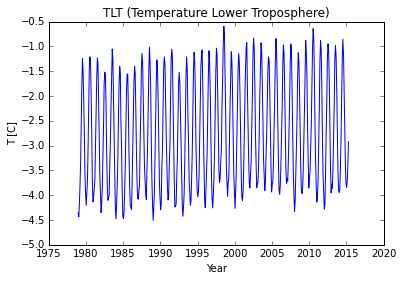

In [17]:
Tavg = average(brightness_temperature, axis=2)
Tavg = average(Tavg, axis=1, weights=w_theta)
plot(years, Tavg-273.15)
xlabel("Year")
ylabel("T [C]")
title("TLT (Temperature Lower Troposphere)")
show()

The temperature oscillates each year. To calculate the "anomaly", we subtract from each month its average temperature:

In [18]:
Tanom = empty(Tavg.shape)
for i in range(12):
    Tanom[i::12] = Tavg[i::12] - average(Tavg[i::12])

We calculate linear fit

In [19]:
from scipy.stats import linregress
# Skip the first year, start from 1979, that's why you see the "12" here and below:
n0 = 12 # use 276 for the year 2001
Y0 = years[n0]
a, b, _, _, adev = linregress(years[n0:]-Y0, Tanom[n0:])
print "par              dev"
print a, adev
print b

par              dev
0.0121199644003 0.000778193323353
-0.21878386072


And compare against official graph + trend. As can be seen, the agreement is perfect:

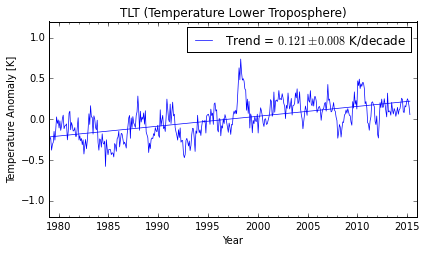

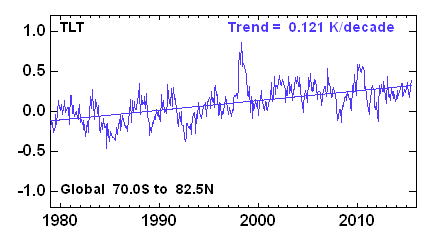

In [20]:
from matplotlib.ticker import MultipleLocator
figure(figsize=(6.6, 3.5))
plot(years, Tanom, "b-", lw=0.7)
plot(years, a*(years-Y0)+b, "b-", lw=0.7, label="Trend = $%.3f \pm %.3f$ K/decade" % (a*10, adev*10))
xlim([1979, 2016])
ylim([-1.2, 1.2])
gca().xaxis.set_minor_locator(MultipleLocator(1))
legend()
xlabel("Year")
ylabel("Temperature Anomaly [K]")
title("TLT (Temperature Lower Troposphere)")
show()
Image(url="http://www.remss.com/data/msu/graphics/TLT/plots/RSS_TS_channel_TLT_Global_Land_And_Sea_v03_3.png", embed=True)